In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def knapsack_recursive(items, C):
    """
    items: a list of (weight, value) pairs
    C: the maximum total weight
    
    Returns (best value, list of items in a solution)
    """
    if len(items) == 0:
        return (0, [])
    w, v = items[0]
    soln_without = knapsack_recursive(items[1:], C)
    if w > C:
        return soln_without
    else:
        value, choices = knapsack_recursive(items[1:], C - w)
        soln_with = (value + v, [(w, v)] + choices)
        return max(soln_with, soln_without)    

In [3]:
# Check on some examples.

items = [(3,4)]
print(knapsack_recursive(items, 2))
items = [(3,4), (5,4), (6,5), (9,7)]
print(knapsack_recursive(items, 9))
items = [(3,4), (5,4), (6,5), (9,7), (1,2)]
print(knapsack_recursive(items, 9))


(0, [])
(9, [(3, 4), (6, 5)])
(10, [(3, 4), (5, 4), (1, 2)])


In [4]:
#How does this scale? let's try random instances:
import random

def make_instance(n, maxW, maxV):
    items = [(random.randint(1, maxW), random.randint(1, maxV)) for _ in range(n)]
    # Capacity such that we will take Theta(n) items
    C = n*maxW // 3
    return (items, C)

for n in [1, 10, 15, 20, 21]:
    print(f"n = {n}:")
    %timeit knapsack_recursive(*make_instance(n, 1000,1000))

n = 1:
2.47 µs ± 23.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n = 10:
583 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n = 15:
18.4 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 20:
573 ms ± 66.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
n = 21:
1.11 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Let's try the same `memoize` as pset 1
# (slightly modified to work with mutable inputs)
import functools
import pickle

def memoize(f):
    """This can turn any recursive function into a memoized version."""
    cache = {}
    @functools.wraps(f)
    def wrap(*args):
        args_hash = pickle.dumps(args)
        if args_hash not in cache:
            cache[args_hash] = f(*args)  
        return cache[args_hash]
    wrap.cache = cache                #so we can clear it as needed
    return wrap

In [6]:
# BAM, suddenly "knapsack_recursive" is memoized.
knapsack_recursive = memoize(knapsack_recursive)

%timeit -n 1 knapsack_recursive(*make_instance(21, 1000,1000))

159 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# OK, there's an issue with using @memoize for timing, which is that the cache is shared
# across multiple calls.  This creates a new function, knapsack_memoized, that clears
# the cache.

@functools.wraps(knapsack_recursive)
def knapsack_memoized(*args):
    knapsack_recursive.cache = {}
    return knapsack_recursive(*args)

In [8]:
items = [(3,4), (5,4), (6,5), (9,7), (1,2)]
print(knapsack_memoized(items, 9))
for n in [1, 10, 15, 20, 21, 50]:
    print(f"n = {n}:")
    %timeit knapsack_memoized(*make_instance(n, 1000,1000))

(10, [(3, 4), (5, 4), (1, 2)])
n = 1:
4.35 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n = 10:
2.24 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 15:
32.7 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 20:
133 ms ± 9.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 21:
159 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 50:
2.65 s ± 388 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


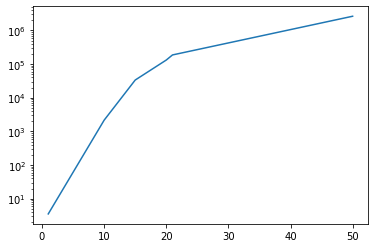

In [21]:
x = [1, 10, 15, 20, 21, 50]
y = [3.53, 2.16e3, 33.6e3, 132e3, 187e3, 2.64e6]
plt.semilogy(x, y)
plt.show()

Question (a):
------------

What are the big-O time and space complexity of `knapsack_memoized`?  Give your answer both as a function of `n` and `C`, and as a function of `n` for an instance of `make_instance(n, 1000, 1000)`.

[Hint: the way it maintains the answer set might make it slower than you expect.]


**O(C 2^n) for both time and space complexity, because we have 2^n choices for the item list and C choices for the capacity.**

In [10]:
# Now let's try the bottom-up DP, with a sliding window.

def knapsack_value(items, C):
    best = [0]*(C+1)
    for w, v in items:
        # By iterating t from the end to the beginning, we can keep only one column
        for t in range(C, w-1, -1):
            best[t] = max(best[t], best[t-w]+v)
    return best[C]

In [11]:
items = [(3,4), (5,4), (6,5), (9,7), (1,2)]
print(knapsack_value(items, 9))
for n in [1, 10, 15, 20, 21, 50]:
    print(f"n = {n}:")
    %timeit knapsack_value(*make_instance(n, 1000,1000))

10
n = 1:
13.9 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n = 10:
6.04 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 15:
14.5 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
n = 20:
26.6 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 21:
29.3 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
n = 50:
177 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# Python loops are slow.  Let's make it faster by making the inner loop an array operation,
# which numpy can do 50-100 times faster than python loops.

def knapsack_value_numpy(items, C):
    best = np.zeros(C+1)
    for w, v in items:
        best[w:] = np.max([best[w:], best[:-w] + v], axis=0)
    return best[C]

In [13]:
items = [(3,4), (5,4), (6,5), (9,7), (1,2)]
print(knapsack_value_numpy(items, 9))
for n in [1, 10, 15, 20, 21, 50]:
    print(f"n = {n}:")
    %timeit knapsack_value_numpy(*make_instance(n, 1000,1000))

10.0
n = 1:
13.9 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n = 10:
221 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n = 15:
412 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n = 20:
631 µs ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n = 21:
668 µs ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n = 50:
3.03 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# Timing code from fibonacci

import timeit

def smarter_timeit(f, min_total_time=0.1):
    """Figure out how long f() takes to run.
    
    To make the timing reliable, run the function enough times to take min_time seconds overall.
    """
    number = 1
    while True:
        total_time = timeit.timeit(f, number=number)
        if total_time > min_total_time:
            return total_time / number
        number *= 2
        
# Get all the data
def get_times(func, base=1.01, max_val=None, max_time=2, min_time=0.5):
    """Get the running time for a given function at many different n.
    
    Gets the time to compute func(n) for n growing up until it takes
    max_time seconds to compute func(n), and return a pair of lists:
    the times and corresponding ns. 
    """
    nums = []
    vals = []
    for i in range(1000):
        n = int(base**i)
        if nums and n == nums[-1]:
            continue
        if max_val is not None and n > max_val:
            break
        t = smarter_timeit(lambda: func(n), min_time)
        nums.append(n)
        vals.append(t)
        if t > max_time:
            break
    return nums, vals

In [15]:
funcs = [('memoized', knapsack_memoized),
         ('bottom-up', knapsack_value),
         ('bottom-up numpy', knapsack_value_numpy),
        ]

timings = {}

for label, f in funcs:
    timings[label] = get_times(lambda n: f(*make_instance(n, 1000,1000)), 1.4)

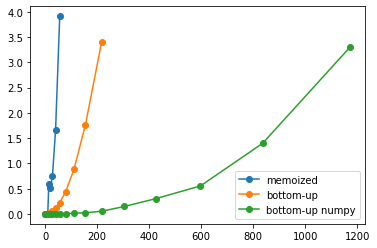

In [16]:
for label, times in timings.items():
    plt.plot(*times, marker='o', label=label)
plt.legend()

[]

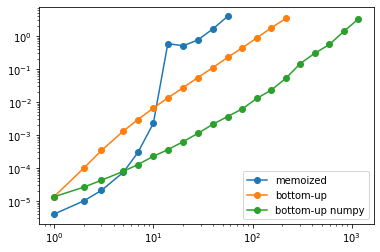

In [17]:
for label, times in timings.items():
    plt.plot(*times, marker='o', label=label)
plt.legend()
plt.loglog()

Question (b):
----------------

In our input instances, both the weights and values are small integers, bounded by `B = 1000`.  What is the running time as a function of `n` and `B`?

Does the growth with `n` conform to what you see on this log-log plot?

O(nC) because C scales as n*B, so O(n^2*B)

T = a*n^2

log(T) = a + 2*log(n)
if we were correct, the relation should be a linear line with a slope of 2 on the loglog plot. In the plot, the slope of the bottom-up is slightly larger than 2 and the slope of the np version is less than 2, due to some overhead and optimization/vectorized calculations with numpy.





Question (c):
--------------
Implement a version of `knapsack_value` or `knapsack_value_numpy` that also finds the set of items.

(You may use O(nC) space if you prefer.  Also implementing the O(C) space algorithm, and comparing to the O(nC) space algorithm, is a fun challenge.)

In [48]:
def knapsack_set(items, C):
    best = [0]*(C+1)
    best_set = [[]]*(C+1)
    for w, v in items:
        # By iterating t from the end to the beginning, we can keep only one column
        for t in range(C, w-1, -1):
            if best[t] < best[t-w] + v:
                best[t] = best[t-w] + v
                best_set[t] = (w, v)
    solution = []
    w_left = C
    while w_left > 0:
        if best_set[w_left]:
            w, v = best_set[w_left]
            solution.append((w, v))
        w_left -= w
    return solution

In [49]:
items = [(3,4), (5,4), (6,5), (9,7), (1,2)]
print(knapsack_set(items, 9))

[(1, 2), (5, 4), (3, 4)]


Question (d)
----------------

How does the timing of your `knapsack_set` compare to `knapsack_value`, both theoretically and empirically?

The extra part is to get the set from the last item list at each C through the while loop, which takes O(n). So the over all time compleixty for the knapset_set algorithm is still O(n^2).

This is confirmed by the plot below.

In [50]:
funcs = [
         ('value', knapsack_value),
         ('set', knapsack_set),
        ]

timings = {}

for label, f in funcs:
    timings[label] = get_times(lambda n: f(*make_instance(n, 1000,1000)), 1.4)

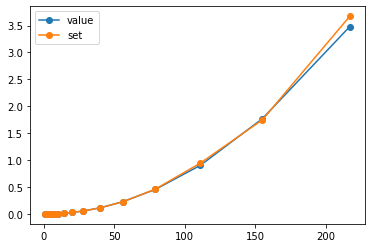

In [53]:
for label, times in timings.items():
    plt.plot(*times, marker='o', label=label)
plt.legend()

Question (e)   _(optional)_ 
------------

The knapsack problem is in general NP-hard when both the weights and values are arbitrary real numbers.
However, _random instances_ like those generated by `make_instance(n, 2**30, 2**30)` are actually easy to
solve in polynomial time with high probability.

Design and implement an algorithm that can do so.  (No proof necessary, just empirical evidence)

Hint: The `best` array from knapsack_value is usually highly redundant, and the set of "Pareto-optimal" (weight, value) possibilities is much smaller.

In [19]:
def knapsack_value_high(items, C):
    ...
    return best[-1][1]

In [20]:
random.seed(3)
print(knapsack_value_high(*make_instance(100, 2**30,2**30)))
# Should give: 48957779005

%timeit knapsack_value_high(*make_instance(100, 2**30,2**30))
# My code is 10 lines long and takes 11 ms per loop


NameError: name 'best' is not defined